In [5]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import dask.dataframe as dd
import dask
from collections import defaultdict
from pathlib import Path
import torch
from tqdm.notebook import tqdm


# Import our utility functions
sys.path.append('..')
from notebooks.file_structure_utils import (
    get_image_path,
    get_available_channels,
)

data_dir = '/orcd/data/omarabu/001/njwfish/DistributionEmbeddings/data/ops'

In [35]:
pdf = pd.read_parquet(
    data_dir+'/interphase-reclassified_cp_phenotype_normalized.parquet', 
    columns=['gene_symbol_0', 'plate', 'tile', 'well', 'bounds_0', 'bounds_1', 'bounds_2', 'bounds_3']
)

In [81]:
import torch
import torch.nn.functional as F

def center_pad_tensor(img_tensor: torch.Tensor, target_size: tuple, pad_value: float = 0.0):
    """
    Center pad a 3D tensor (C x H x W) to the given target size.
    
    Args:
        img_tensor: torch.Tensor of shape (C, H, W)
        target_size: Tuple (target_height, target_width)
        pad_value: Scalar to use for padding.
        
    Returns:
        torch.Tensor of shape (C, target_height, target_width)
    """
    _, h, w = img_tensor.shape
    target_h, target_w = target_size

    pad_h = max(target_h - h, 0)
    pad_w = max(target_w - w, 0)

    # Padding format for 3D tensor is (pad_w_left, pad_w_right, pad_h_top, pad_h_bottom)
    padding = [
        pad_w // 2, pad_w - pad_w // 2,
        pad_h // 2, pad_h - pad_h // 2
    ]

    return F.pad(img_tensor, padding, value=pad_value)


def build_crop_dict(parquet_df, max_height=104, max_width=104, n_imgs=10):
    
    df = parquet_df
 
    print('grouping by img, this takes ~1m')
    grouped = defaultdict(list)
    for row in df.itertuples():
        grouped[(row.plate, row.well, row.tile)].append([
            row.gene_symbol_0, 
            row.bounds_0, row.bounds_1, 
            row.bounds_2, row.bounds_3
        ])

    pert_dict = defaultdict(list)

    for img_number, (img_path, entries) in tqdm(enumerate(grouped.items())):
        plate, well, tile = img_path
        available_channels = get_available_channels(plate, well, tile, base_dir=data_dir)
        
        if 'DAPI-GFP' in available_channels:
            image_path = get_image_path(plate, well, tile, 'DAPI-GFP', data_dir, 'screenA')
            
            # Check if file exists
            if not image_path or not os.path.exists(image_path):
                print(f"Warning: File not found")
                continue
                
            # Load full image
            full_image = io.imread(image_path)
            if len(full_image.shape) == 4 and full_image.shape[1] == 2:
                # only use the first channel of the image since they are basically the same (diff resolutions maybe)
                dapi_image = full_image[0, 0]
                gfp_image = full_image[0, 1]

                for ent in entries:
                    # if the cell is too big, crop it to the max size
                    if (ent[3] - ent[1]) > max_height:
                        ent[1] = ent[1] + (ent[3] - ent[1] - max_height) // 2
                        ent[3] = ent[1] + max_height
                    if (ent[4] - ent[2]) > max_width:
                        ent[2] = ent[2] + (ent[4] - ent[2] - max_width) // 2
                        ent[4] = ent[2] + max_width
                    dapi_cell_image = torch.tensor(dapi_image[ent[1]:ent[3], ent[2]:ent[4]])
                    gfp_cell_image = torch.tensor(gfp_image[ent[1]:ent[3], ent[2]:ent[4]])
                    stacked_image = torch.stack([
                        torch.tensor(dapi_cell_image), 
                        torch.tensor(gfp_cell_image)
                    ])
                    padded_stacked_image = center_pad_tensor(stacked_image, (max_height, max_width))
                    pert_dict[ent[0]].append(padded_stacked_image)

        if img_number > n_imgs:
            break

    return pert_dict  # {perturbation: [list of (2, h, w)]}

In [82]:
cd = build_crop_dict(pdf, max_height=60, max_width=60, n_imgs=10)

grouping by img, this takes ~1m


0it [00:00, ?it/s]

/tmp/ipykernel_4185045/2271490153.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dapi_cell_image),
/tmp/ipykernel_4185045/2271490153.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(gfp_cell_image)
/tmp/ipykernel_4185045/2271490153.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dapi_cell_image),
/tmp/ipykernel_4185045/2271490153.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tr

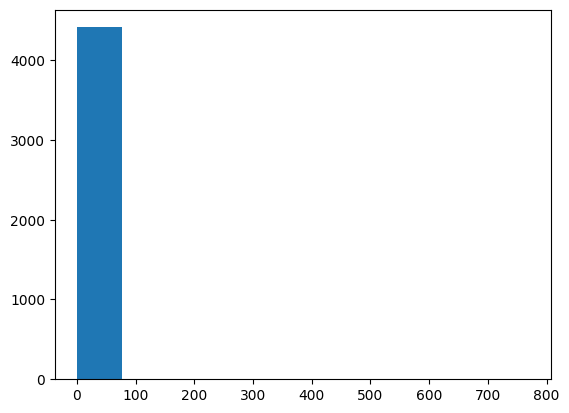

total cells:  31552
total perts:  4414
number of nontargeting:  769


In [33]:
counts = {k:len(v) for k,v in cd.items()}
plt.hist(list(counts.values()))
plt.show()

print('total cells: ', sum(list(counts.values())))
print('total perts: ', len(counts))
print('number of nontargeting: ', counts['nontargeting'])

DAPI:


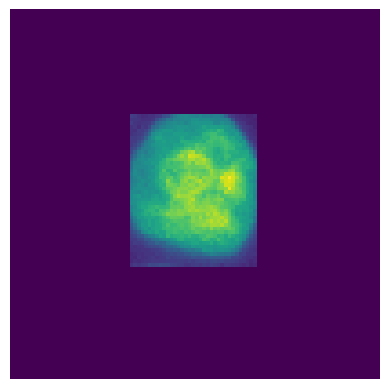

GFP:


(-0.5, 101.5, 101.5, -0.5)

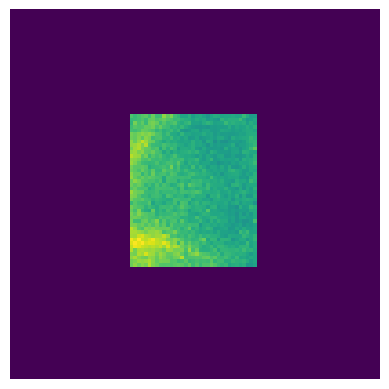

In [76]:
print('DAPI:')
plt.imshow(cd['CCNT1'][5][0, :, :])
plt.axis('off')
plt.show()
print('GFP:')
plt.imshow(cd['CCNT1'][5][1, :, :])
plt.axis('off')